# Gesture Recognition


In [8]:
!pip install scipy

In [12]:
!pip install matplotlib

In [10]:
import numpy as np
import os
from scipy import misc
import datetime

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [21]:
import numpy as np
import os
import datetime

def imread(path):
    from PIL import Image
    return np.array(Image.open(path))

def imresize(img, size):
    from PIL import Image
    return np.array(Image.fromarray(img).resize(size))

We set the random seed so that the results don't vary drastically.

In [13]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [14]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [34]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                                        
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [35]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model


## Conv3D model

In [ ]:
model2 = Sequential()
model2.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
#model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model2.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        
filepath = '/content/gdrive/My Drive/DL Notebooks/Gesture Recognition Data/'+ model_name + 'model2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_13 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 7, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 7, 60, 60, 32)    

In [ ]:
history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
30/34 [=========================>....] - ETA: 7s - loss: 1.4781 - categorical_accuracy: 0.4483

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


34/34 [==============================] - ETA: 0s - loss: 1.4301 - categorical_accuracy: 0.4630
Epoch 00001: saving model to model_init_2022-01-1710_28_36.621133/model2-00001-1.43009-0.46305-7.50190-0.23000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.4301 - categorical_accuracy: 0.4630 - val_loss: 7.5019 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
31/34 [==========================>...] - ETA: 5s - loss: 0.9442 - categorical_accuracy: 0.6484

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


34/34 [==============================] - ETA: 0s - loss: 0.9395 - categorical_accuracy: 0.6486
Epoch 00002: saving model to model_init_2022-01-1710_28_36.621133/model2-00002-0.93948-0.64857-5.27808-0.26000.h5
34/34 [==============================] - 72s 2s/step - loss: 0.9395 - categorical_accuracy: 0.6486 - val_loss: 5.2781 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7646 - categorical_accuracy: 0.7240
Epoch 00003: saving model to model_init_2022-01-1710_28_36.621133/model2-00003-0.76463-0.72398-2.75078-0.34000.h5
34/34 [==============================] - 80s 2s/step - loss: 0.7646 - categorical_accuracy: 0.7240 - val_loss: 2.7508 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.5489 - categorical_accuracy: 0.7979
Epoch 00004: saving model to model_init_2022-01-1710_28_36.621133/model2-00004-0.54889-0.79789-2.31277-0.43000.h5
34/34 [============

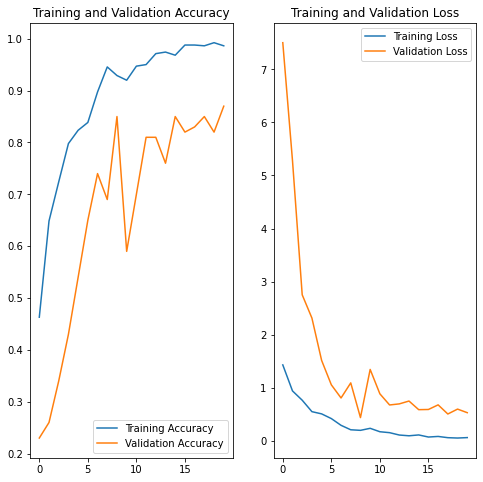

In [ ]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### This model looks better than earlier models with training accuracy 98% and validation accuracy as 87%.


## Transfer Learning - Using resnet50 without training weights

In [40]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50
    
base_model = ResNet50(include_top=False, weights='imagenet')
        
model5 = Sequential()
model5.add(TimeDistributed(base_model, input_shape=(15,120,120,3)))
for layer in base_model.layers:
    layer.trainable = False
    
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))
model5.add(TimeDistributed(Flatten()))

model5.add(LSTM(64))
model5.add(Dropout(0.25))
        
model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(5, activation='softmax'))
        
optimiser = optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model5.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        
filepath = model_name + 'model5-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 4, 4, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 8192)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 64)               

In [41]:
history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\itzmu\AppData\Local\Temp/ipykernel_18012/2558664409.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3578 - categorical_accuracy: 0.4434
Epoch 00001: saving model to model_init_2022-01-1914_52_50.134304\model5-00001-1.35780-0.44344-1.03678-0.71000.h5
34/34 [==============================] - 40s 1s/step - loss: 1.3578 - categorical_accuracy: 0.4434 - val_loss: 1.0368 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9132 - categorical_accuracy: 0.7029
Epoch 00002: saving model to model_init_2022-01-1914_52_50.134304\model5-00002-0.91318-0.70287-0.64316-0.86000.h5
34/34 [==============================] - 35s 1s/step - loss: 0.9132 - categorical_accuracy: 0.7029 - val_loss: 0.6432 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5871 - categorical_accuracy: 0.8371
Epoch 00003: saving model to model_init_2022-01-1914_52_50.134304\model5-00003-0.58713-0.83710-0.35436-0.95000.h5
34/34 [=

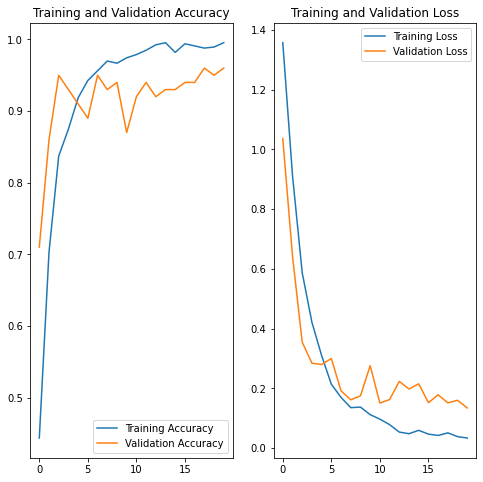

In [42]:
acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()	

### This is the final Model with below metrics. Peformance is good on both Training and Validation data set
- Training loss: 0.0331
- categorical_accuracy: 0.9955
- val_loss: 0.1339
- val_categorical_accuracy: 0.9600

## hence, This is the Final Model.